In [1]:
# Import some of the basis required functions
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import networkx as nx
from scipy.stats import norm
import matplotlib.pyplot as plt
import ffn 
from matplotlib import collections as matcoll


In [11]:
# Exercise 1: Monte Carlo Simulation
class MonteCarlo():
    def __init__(self,sigma = np.sqrt(12)*0.0428156, rf = None, K = 3300):
        rf = (1+0.005/4)**4 - 1
        # Monthly std from last assignment
        self.sigma = sigma
        # Risk free interest rate per month
        self.rf    = rf
        self.K     = K
        self.S0    = ffn.get('^GSPC:Close', start='2020-08-31',end='2020-08-31').values[0][0]
        
    def propagate(self,Sn,dT):
        phis = np.random.randn(len(Sn))
        return Sn + Sn * (self.rf*dT + self.sigma*np.sqrt(dT)*phis)
            
    def payout(self,prices,T,M):
        payoff = prices - self.K
        return (np.exp(-1*self.rf * T) / M )* np.sum(payoff)
    
    def simulate(self,M,N,T):
        # Generate array of length M with values for phi
        dT = T/N
        prices = np.ones(M) * self.S0
        for i in range(N):
            prices = self.propagate(prices,dT)
        payout = self.payout(prices,T,M)
        return payout
    
    def stochastic_differential(self,M,T):
        phis = np.random.randn(M)
        prices = self.S0 * np.exp((self.rf - 0.5*self.sigma**2)*T
                                  +self.sigma*np.sqrt(T)*phis)
        return prices
    
    def stochastic_payout(self,M,T):
        prices = self.stochastic_differential(M,T)
        payoff = prices - self.K
        return (np.exp(-1*self.rf * T))* np.mean(payoff)
    
    def black_scholes(self,T,call_put='call'):   
        S = self.S0
        K = self.K
        sigma = self.sigma
        r = self.rf
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

        if call_put == 'call':
            optionprice = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
        elif call_put == 'put':
            optionprice = (K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
        self.BSprice = optionprice
        
    def plot_convergence(self,M_arr,values,M_many,values_many):
        plt.figure()
        plt.scatter(M,values,color='red')
        plt.plot(M_many,values_many, color='black', label='Simulation',alpha=0.3)
        plt.ylabel('Option price at inception (USD)', size=13)
        plt.xlabel('Number of simulations', size=13)
        plt.axhline(self.BSprice, label='Black-Scholes limit',ls='dotted')
        plt.legend(loc='best', fontsize=12)
        plt.tight_layout()
        

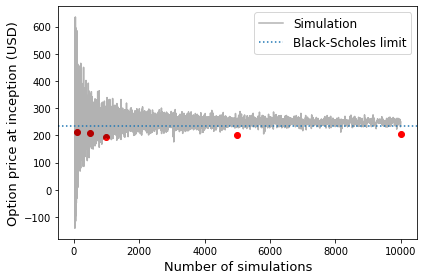

In [12]:
# Exercise a
MC = MonteCarlo()
M = np.array([100,500,1000,5000,10000])
call_values = [MC.simulate(w,3,0.25) for w in M]
M_many = np.logspace(1.5,4,10000,dtype=int)
call_values_many = Parallel(n_jobs=22)(delayed(MC.simulate)(N,3,3) for N in M_many)
MC.black_scholes(T=0.25)
MC.plot_convergence(M,call_values,M_many,call_values_many)

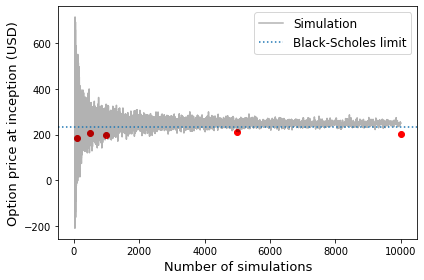

In [13]:
# Exercise b
MC = MonteCarlo()
M = np.array([100,500,1000,5000,10000])
call_values = [MC.simulate(w,63,0.25) for w in M]
M_many = np.logspace(1.5,4,10000,dtype=int)
call_values_many = Parallel(n_jobs=22)(delayed(MC.simulate)(N,63,3) for N in M_many)
MC.black_scholes(T=0.25)
MC.plot_convergence(M,call_values,M_many,call_values_many)

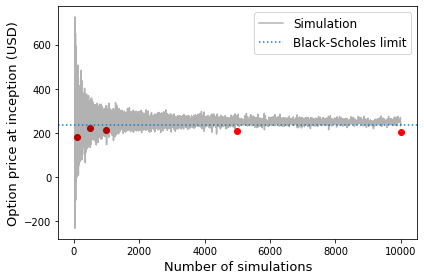

In [14]:
# Exercise c
MC = MonteCarlo()
M = np.array([100,500,1000,5000,10000])
call_values = [MC.stochastic_payout(w,0.25) for w in M]
M_many = np.logspace(1.5,4,10000,dtype=int)
call_values_many = Parallel(n_jobs=22)(delayed(MC.stochastic_payout)(N,3) for N in M_many)
MC.black_scholes(T=0.25)
MC.plot_convergence(M,call_values,M_many,call_values_many)